In [1]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy, TripletLoss, CircleLoss
from train import train_epoch_mmd

from dataset import dataset
from scipy import sparse

import utils
import model
import train
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.preprocessing import LabelEncoder
from metrics import *
import anndata as ad

In [2]:
le = LabelEncoder()

## New version for 8 batches
There seems to be some issue with the original implementation, so I re-write the training and dataset generation code. The clusters are better separated this time. Please check the new code when you have time.

-Ziqi

In [3]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point, batch_id, group_id):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        if anno == None:
            self.anno = None
        else :
            torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        self.time_point = torch.Tensor(time_point)
        self.group_id = torch.Tensor(group_id)
        self.batch_id = torch.Tensor(batch_id)

    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"batch_id": self.batch_id[idx], "group_id": self.group_id[idx], "time_point": self.time_point[idx] , "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"batch_id": self.batch_id[idx], "group_id": self.group_id[idx], "time_point": self.time_point[idx] ,"count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample


In [4]:
batch_info = pd.read_csv(r'./data/GSE99915/processed/batch_info.csv')

In [5]:
len(batch_info.index)
batch_info

,Unnamed: 0,HF1,HF2
0,batch_1,"(3095, 8553)","(10113, 8553)"
1,batch_2,"(1079, 8553)","(6864, 8553)"
2,batch_3,"(4956, 8553)","(3871, 8553)"
3,batch_4,"(2737, 8553)","(3677, 8553)"
4,batch_5,"(5665, 8553)","(4970, 8553)"
5,batch_6,"(3812, 8553)","(5275, 8553)"
6,batch_7,"(2496, 8553)","(11367, 8553)"
7,batch_8,"(9045, 8553)","(12695, 8553)"


# I buid two types of train_loaders:
### 1. each dataset in <font color = red>sc_datasets_raw </font> only contains one batch (as normal)
### 2. each dataset in <font color = red>sc_datasets </font> contains two batches, which is the HF1 and HF2 file from the same time point(i.e. sc_datasets[0] is batch_1_HF_1 + batch_1_HF_2 in order to make it simple in code for training function

In [6]:
dir = './data/GSE99915/processed/'

batchsize = 32
ngenes = 8553
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

sc_datasets = []
sc_datasets_raw = []
train_loaders = []
test_loaders = []
train_loaders_raw = []
test_loaders_raw = []
n = 0
for batch_id in range(1,9):
    time_points = []
    counts_rnas = []
    group_ids = []
    batch_ids = []
    for n in range(1, 3):
        counts_rna = np.array(sparse.load_npz(os.path.join(dir, 'mtx_HF_{}_batch_{}.npz'.format(n, batch_id))).todense())
        counts_rnas.append(counts_rna)
        time_points.append([batch_id] * counts_rna.shape[0])
        group_ids.append([n] * counts_rna.shape[0])
        batch_ids.append([(batch_id-1)*2 + n - 1] * counts_rna.shape[0])
        print('mtx_HF_{}_batch_{}.npz'.format(n, batch_id), 'finished!')
        sc_dataset_raw =  dataset(counts = counts_rna,anno = None, time_point = [batch_id] * counts_rna.shape[0], 
                         group_id = [n] * counts_rna.shape[0], 
                         batch_id = [(batch_id-1)*2 + n - 1] * counts_rna.shape[0])
        sc_datasets_raw.append(sc_dataset_raw)
        train_loaders_raw.append(DataLoader(sc_dataset_raw, batch_size = batchsize, shuffle = True))
        test_loaders_raw.append(DataLoader(sc_dataset_raw, batch_size = len(sc_dataset_raw), shuffle = False))
        
    sc_dataset = dataset(counts = counts_rna,anno = None, time_point = np.concatenate(time_points), 
                         group_id = np.concatenate(group_ids), 
                         batch_id = np.concatenate(batch_ids))
    sc_datasets.append(sc_dataset)
    train_loaders.append(DataLoader(sc_dataset, batch_size = batchsize, shuffle = True))
    test_loaders.append(DataLoader(sc_dataset, batch_size = len(sc_dataset), shuffle = False))

nbatches = len(sc_datasets_raw)

mtx_HF_1_batch_1.npz finished!
mtx_HF_2_batch_1.npz finished!
mtx_HF_1_batch_2.npz finished!
mtx_HF_2_batch_2.npz finished!
mtx_HF_1_batch_3.npz finished!
mtx_HF_2_batch_3.npz finished!
mtx_HF_1_batch_4.npz finished!
mtx_HF_2_batch_4.npz finished!
mtx_HF_1_batch_5.npz finished!
mtx_HF_2_batch_5.npz finished!
mtx_HF_1_batch_6.npz finished!
mtx_HF_2_batch_6.npz finished!
mtx_HF_1_batch_7.npz finished!
mtx_HF_2_batch_7.npz finished!
mtx_HF_1_batch_8.npz finished!
mtx_HF_2_batch_8.npz finished!


In [7]:
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/reprogram/'

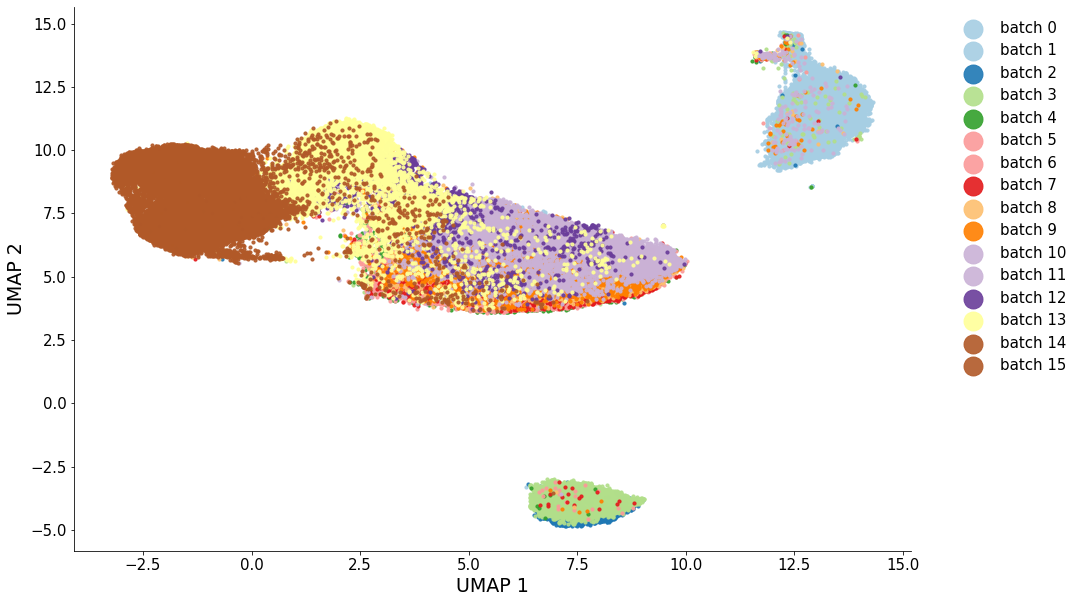

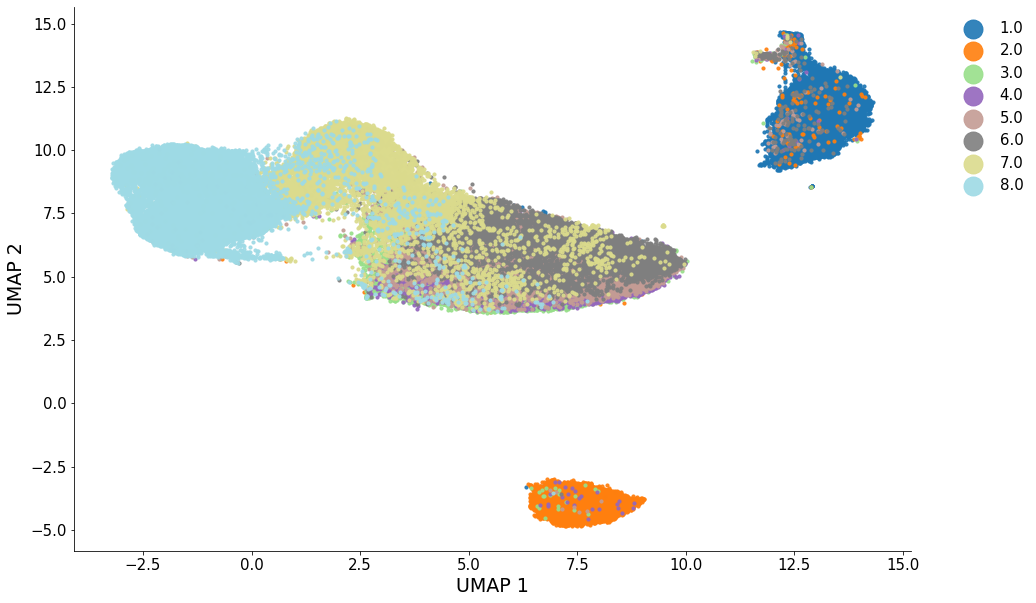

In [8]:
# before integration
nbatches = len(sc_datasets_raw)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.1, random_state = 0) 
counts_norms = []
annos = []
batch_ids = []
for batch in range(nbatches):
    counts_norms.append(sc_datasets_raw[batch].counts_norm)
    annos.append(sc_datasets_raw[batch].time_point)
    batch_ids.append(sc_datasets_raw[batch].batch_id)

x_umap = umap_op.fit_transform(np.concatenate(counts_norms, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
save_file = None
save_file_1 = path + 'original_batch.png'
save_file_2 = path + 'original_time_point.png'

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


In [9]:
import importlib
importlib.reload(train)

<module 'train' from './src/train.py'>

In [10]:
class InfoNCE(nn.Module):
    """
    Calculates the InfoNCE loss for self-supervised learning.
    This contrastive loss enforces the embeddings of similar (positive) samples to be close
        and those of different (negative) samples to be distant.
    A query embedding is compared with one positive key and with one or more negative keys.
    References:
        https://arxiv.org/abs/1807.03748v2
        https://arxiv.org/abs/2010.05113
    Args:
        temperature: Logits are divided by temperature before calculating the cross entropy.
        reduction: Reduction method applied to the output.
            Value must be one of ['none', 'sum', 'mean'].
            See torch.nn.functional.cross_entropy for more details about each option.
        negative_mode: Determines how the (optional) negative_keys are handled.
            Value must be one of ['paired', 'unpaired'].
            If 'paired', then each query sample is paired with a number of negative keys.
            Comparable to a triplet loss, but with multiple negatives per sample.
            If 'unpaired', then the set of negative keys are all unrelated to any positive key.
    Input shape:
        query: (N, D) Tensor with query samples (e.g. embeddings of the input).
        positive_key: (N, D) Tensor with positive samples (e.g. embeddings of augmented input).
        negative_keys (optional): Tensor with negative samples (e.g. embeddings of other inputs)
            If negative_mode = 'paired', then negative_keys is a (N, M, D) Tensor.
            If negative_mode = 'unpaired', then negative_keys is a (M, D) Tensor.
            If None, then the negative keys for a sample are the positive keys for the other samples.
    Returns:
         Value of the InfoNCE Loss.
     Examples:
        >>> loss = InfoNCE()
        >>> batch_size, num_negative, embedding_size = 32, 48, 128
        >>> query = torch.randn(batch_size, embedding_size)
        >>> positive_key = torch.randn(batch_size, embedding_size)
        >>> negative_keys = torch.randn(num_negative, embedding_size)
        >>> output = loss(query, positive_key, negative_keys)
    """

    def __init__(self, temperature=0.1, reduction='mean', negative_mode='unpaired'):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction
        self.negative_mode = negative_mode

    def forward(self, query, positive_key, negative_keys=None):
        return info_nce(query, positive_key, negative_keys,
                        temperature=self.temperature,
                        reduction=self.reduction,
                        negative_mode=self.negative_mode)


def info_nce(query, positive_key, negative_keys=None, temperature=0.1, reduction='mean', negative_mode='unpaired'):
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    if negative_keys is not None:
        # Explicit negative keys

        # Cosine between positive pairs
        positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)

        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            negative_logits = query @ transpose(negative_keys)

        elif negative_mode == 'paired':
            query = query.unsqueeze(1)
            negative_logits = query @ transpose(negative_keys)
            negative_logits = negative_logits.squeeze(1)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        logits = query @ transpose(positive_key)

        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)

    return F.cross_entropy(logits / temperature, labels, reduction=reduction)


def transpose(x):
    return x.transpose(-2, -1)


def normalize(*xs):
    return [None if x is None else F.normalize(x, dim=-1) for x in xs]

In [47]:
def train_epoch_mmd(model_dict, train_data_loaders, test_data_loaders, optimizer, 
                    n_epoches = 100, interval = 10, lamb_mmd = 1e-3, lamb_pi = 1e-5, 
                    use_zinb = True, contr_factor=1e-1, contr_loss_group_factor = 5e-2, contr_loss=None, cont=False, time_dim = 5, group_dim = 5):
    group_dim_label = time_dim + group_dim
    loss_zinb_tests = []
    loss_mmd_tests = []
    loss_tests = []
    contr_loss_tests = []
    contr_loss_group = CircleLoss(m=0.25, gamma= 1e-1)
    contr_feature = 'time_point'
    contr_feature_1 = 'group_id'
    for epoch in range(n_epoches + 1):
        # train the model
        for data_batch in zip(*train_data_loaders):
            loss_mmd = 0
            loss_zinb = 0
            loss_contr = 0
            loss_contr_group = 0
            for idx, x in enumerate(data_batch):
                z = model_dict["encoder"](x["count_stand"].to(device))
                mu, pi, theta = model_dict["decoder"](z)
                # negative log likelihood
                if use_zinb:
                    loss_zinb += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(device), y_pred = mu)
                else:
                    # if not use ZINB, then assume the data is Gaussian instead
                    loss_zinb += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()
                    
                # if there are more than 1 batch, calculate mmd loss between current batch and previous batch
                if (len(data_batch) >= 2) & (idx > 0):
                    loss_mmd += maximum_mean_discrepancy(z_pre[:, group_dim_label:], z[:, group_dim_label:])
                    if contr_loss:
                        loss_contr += contr_loss(torch.cat((z[:, :time_dim].to(device), z_pre[:, :time_dim].to(device)), dim=0), torch.cat((x[contr_feature].to(device), label_pre.to(device))))
                        loss_contr_group += contr_loss_group(torch.cat((z[:, time_dim:group_dim_label].to(device), z_pre[:, time_dim:group_dim_label].to(device)), dim=0), torch.cat((x[contr_feature_1].to(device), type_pre.to(device))))
                    else:
                        loss_contr += torch.FloatTensor([0]).to(device)
                else:
                    loss_mmd += torch.FloatTensor([0]).to(device)

                z_pre = z.clone()
                label_pre = (x[contr_feature]).clone()
                type_pre = (x[contr_feature_1]).clone()

            loss = loss_zinb + lamb_mmd * loss_mmd + loss_contr * contr_factor + loss_contr_group * contr_loss_group_factor
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # test the model
        if epoch % interval == 0:
            loss_mmd_test = 0
            loss_zinb_test = 0 
            loss_contr_test = 0
            loss_contr_group_test = 0
            for data_batch in zip(*test_data_loaders):
                with torch.no_grad():
                    for idx, x in enumerate(data_batch):
                        z = model_dict["encoder"](x["count_stand"].to(device))
                        mu, pi, theta = model_dict["decoder"](z)
                        if use_zinb:
                            loss_zinb_test += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x['count'].to(device), y_pred = mu)
                        else:
                            loss_zinb_test += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()

                        if (len(data_batch) >= 2) & (idx > 0):
                            loss_mmd_test += maximum_mean_discrepancy(z_pre[:, group_dim_label:], z[:, group_dim_label:])

                            if contr_loss:
                                loss_contr_test += contr_loss(torch.cat((z[:, :time_dim], z_pre[:, :time_dim]), dim=0), torch.cat((x[contr_feature], label_pre)))
                                loss_contr_group_test += contr_loss_group(torch.cat((z[:, time_dim:group_dim_label], z_pre[:, time_dim:group_dim_label]), dim=0), torch.cat((x[contr_feature_1], type_pre)))
                            else: 
                                loss_contr_test = 0
                        else:
                            loss_mmd_test += torch.FloatTensor([0]).to(device)
                        z_pre = z.clone()
                        label_pre = torch.Tensor(x[contr_feature]).clone()
                        type_pre = torch.Tensor(x[contr_feature_1]).clone()
                        loss_test = loss_zinb_test + lamb_mmd * loss_mmd_test + loss_contr_test * contr_factor + loss_contr_group_test * contr_loss_group_factor

            info = [
                'mmd loss: {:.3f}'.format(loss_mmd_test.item()),
                'ZINB loss: {:.3f}'.format(loss_zinb_test.item()),
                'overall loss: {:.3f}'.format(loss_test.item()),
                'contrastive loss: {:.3f}'.format(loss_contr_test.item()),
            ]

            print("epoch: ", epoch)
            for i in info:
                print("\t", i)
            contr_loss_tests.append(loss_contr_test.item())
            loss_mmd_tests.append(loss_mmd_test.item())
            loss_zinb_tests.append(loss_zinb_test.item())
            loss_tests.append(loss_test.item())
    return loss_tests, loss_mmd_tests, loss_zinb_tests, contr_loss_tests

In [48]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
#         device = (torch.device('cuda')
#                   if features.is_cuda
#                   else torch.device('cpu'))

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
#         contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        contrast_feature = features
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        # tile mask
        print(mask.shape)
#         mask = mask.repeat(anchor_count, contrast_count)

        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(mask).to(device),
            0
        )
        mask = mask * logits_mask
        print(mask.shape)
        # compute log_prob
#         print(logits.shape, logits_mask.shape)
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
#         loss = loss.mean()

        return loss

In [49]:
# initialize the model
ldim = 32
lr = 5e-4
model_dict = {}
model_dict["encoder"] = model.Encoder(features = [ngenes, 256, 32, ldim], dropout_rate = 0, negative_slope = 0.2).to(device)
model_dict["decoder"] = model.Decoder(features = [ldim, 32, 256, ngenes], dropout_rate = 0, negative_slope = 0.2).to(device)
# initialize the optimizer
param_to_optimize = [
    {'params': model_dict["encoder"].parameters()},
    {'params': model_dict["decoder"].parameters()}
]

optim_ae = torch.optim.Adam(param_to_optimize, lr=lr)

# use Circle loss to distinguish different time points
contrastive_loss = CircleLoss(m=0.25, gamma= 1e-2)
# contrastive_loss = TripletLoss(margin=0.3)
# contrastive_loss = torch.nn.CrossEntropyLoss()
# contrastive_loss = SupConLoss()
contr_factor = 1e-1
n_epoches = 30
time_dim = 10
group_dim = 10
losses = train_epoch_mmd(model_dict, train_data_loaders = train_loaders, test_data_loaders = test_loaders, 
                      optimizer = optim_ae, n_epoches = n_epoches, interval = 10, lamb_mmd = 5e-2, 
                      lamb_pi = 1e-5, use_zinb = True, contr_factor=contr_factor,contr_loss=contrastive_loss, 
                        time_dim = time_dim, group_dim = group_dim)

epoch:  0
	 mmd loss: 0.121
	 ZINB loss: 14.019
	 overall loss: 50.716
	 contrastive loss: 244.924
epoch:  10
	 mmd loss: 0.070
	 ZINB loss: 8.033
	 overall loss: 44.715
	 contrastive loss: 244.837
epoch:  20
	 mmd loss: 0.042
	 ZINB loss: 7.972
	 overall loss: 44.652
	 contrastive loss: 244.832
epoch:  30
	 mmd loss: 0.035
	 ZINB loss: 7.914
	 overall loss: 44.592
	 contrastive loss: 244.827


## Loss plot
The change of loss function with iterations

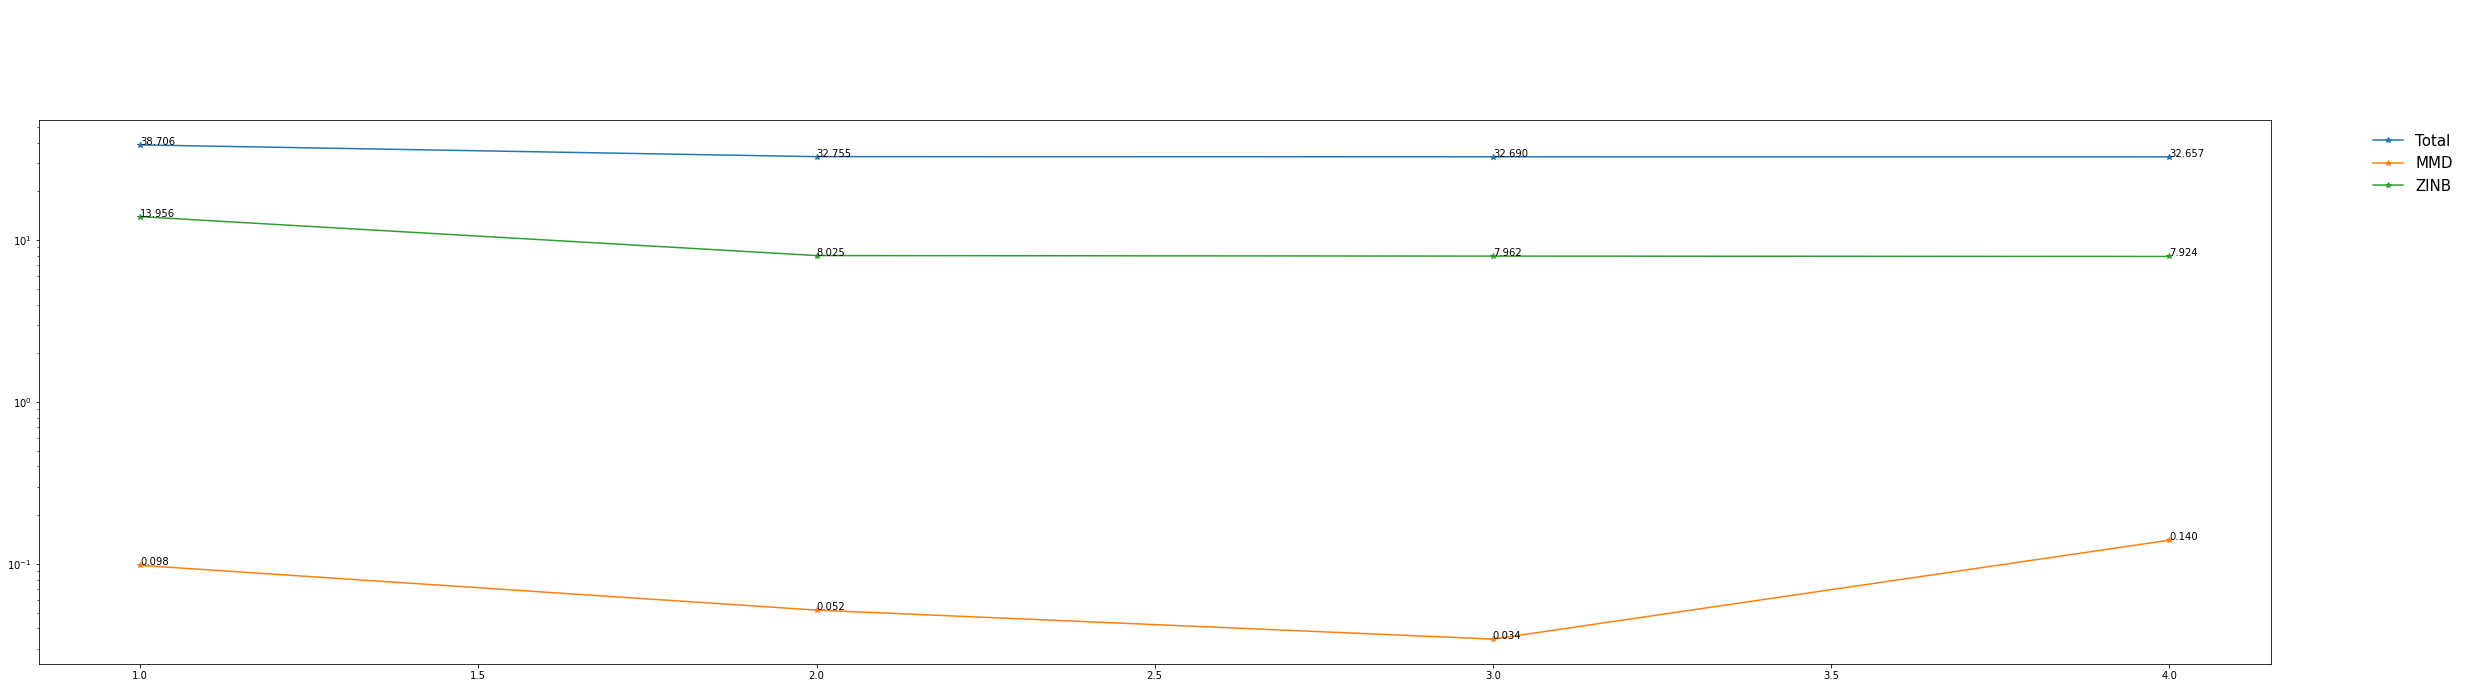

In [35]:

loss_total = losses[0]
loss_mmd = losses[1]
loss_zinb = losses[2]
loss_triplet = losses[3]

iterations = np.arange(1, len(loss_mmd) + 1)
fig = plt.figure(figsize = (40, 10))
ax = fig.add_subplot()
ax.plot(iterations, loss_total, "-*", label = "Total")
ax.plot(iterations, loss_mmd, "-*", label = "MMD")
ax.plot(iterations, loss_zinb, "-*",label = "ZINB")
# ax.plot(iterations, loss_triplet.cpu(), "-*",label = "TRIPLET")
ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
ax.set_yscale("log")
for i,j in zip(iterations,loss_zinb):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_mmd):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_total):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_triplet):
    ax.annotate("{:.3f}".format(j),xy=(i,j)) 

## Ploting only time embeddings

In [46]:
zs = []
import time
batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['time_point'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, :time_dim])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME_DIMS_15_Circle_m_0.1_gamma_0.01'
save_file_id = path + 'id_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2, n_epoches)
save_file_type = path + 'type_contr_{}_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, contr_factor,batch_id_1, batch_id_2,n_epoches )
save_file = None
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Metrics for Benchmarking
**I've implemented: 
        NMI, 
        ARI, 
        graph_connectivity,
to help tune model, mostly referring to CLEAR model and paper "Benchmarking atlas-level data integration in single-cell genomics"** - Xinye


In [ ]:
zs = []
for data_batch in zip(*test_loaders):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            zs.append(z.cpu().detach().numpy())

obs = pd.DataFrame()
data = ad.AnnData(np.concatenate(zs))
data.obs['label'] = pd.Series([str(i) for i in np.concatenate(annos)], dtype="category").values
data.obs['batch'] = pd.Series([str(i) for i in np.concatenate(batch_ids)], dtype="category").values

# ari and nmi
ari_nmi(data, annos, resolution=0.05, show_fig=True)
print('Computing kBET')
print('kBET score:', kBET(data, 'batch', 'label', embed=None))
# print("/nGraph Connectivity Score:", graph_connectivity(data, 'label'))

# These are paris that have similar cell numbers, easily to visualize:
- 0, 6
- 0, 8
- 5, 10
- 4, 9
- 5, 7
- 6, 12
- 1, 13

In [59]:
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/reprogram/rlt_2/'
batch_ids = [0, 6]
save_permit = False

# Visualization of only without group dim

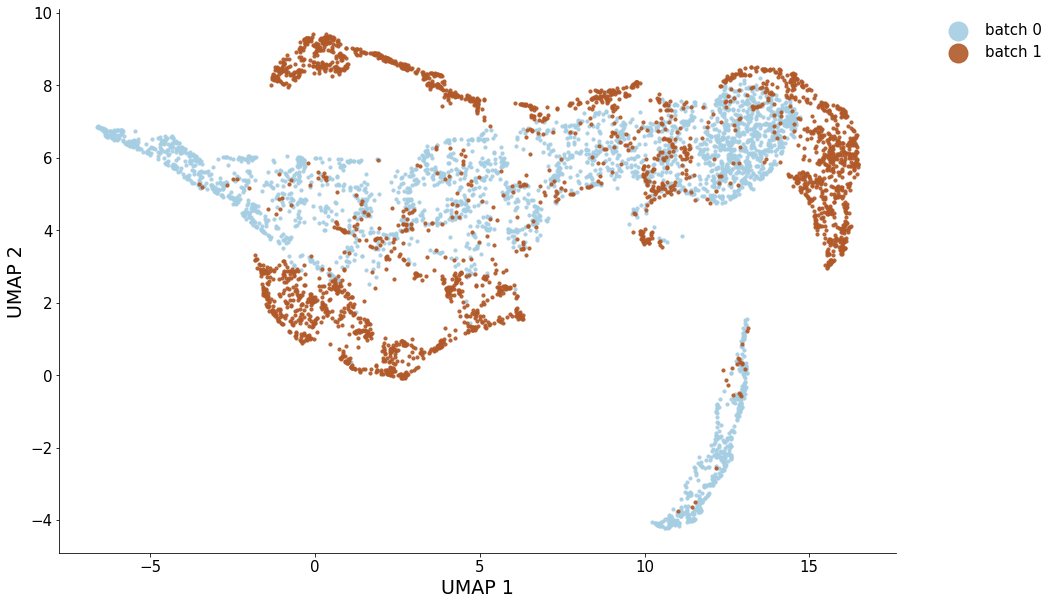

In [60]:
zs = []
import time
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['time_point'])
            zs.append(z.cpu().detach().numpy())
x_umap = umap_op.fit_transform(np.concatenate((np.concatenate(zs, axis = 0)[:, : time_dim], np.concatenate(zs, axis = 0)[:, time_dim + group_dim:]), axis=1))
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_GROUP_DIMS'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = None

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


# Visualization of only without time dim

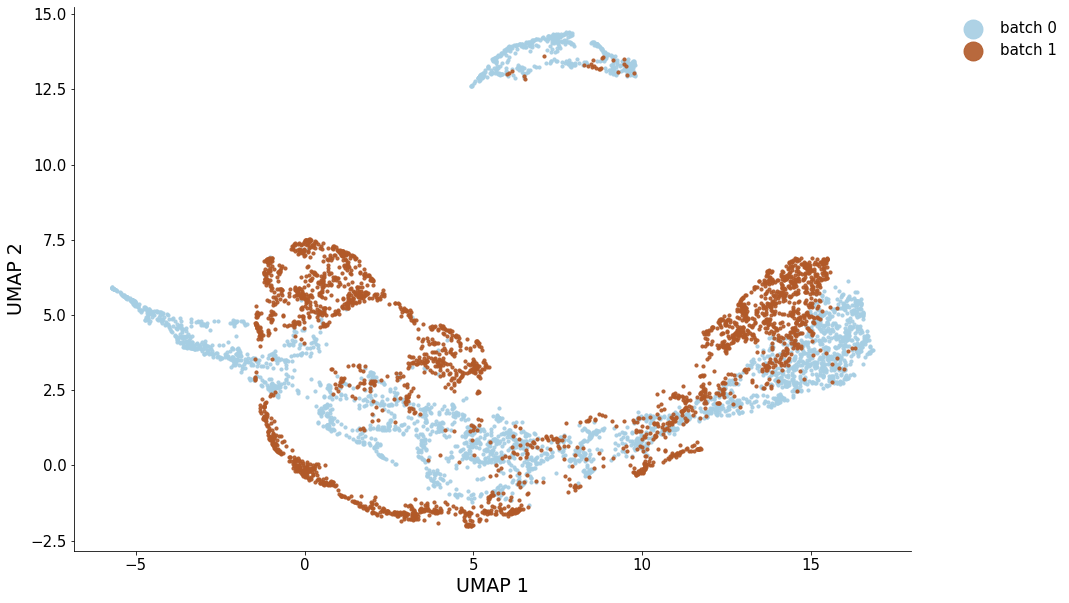

In [61]:
zs = []
import time
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['time_point'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, time_dim:])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME_DIMS'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = None

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualize embedding without time and group dimentions

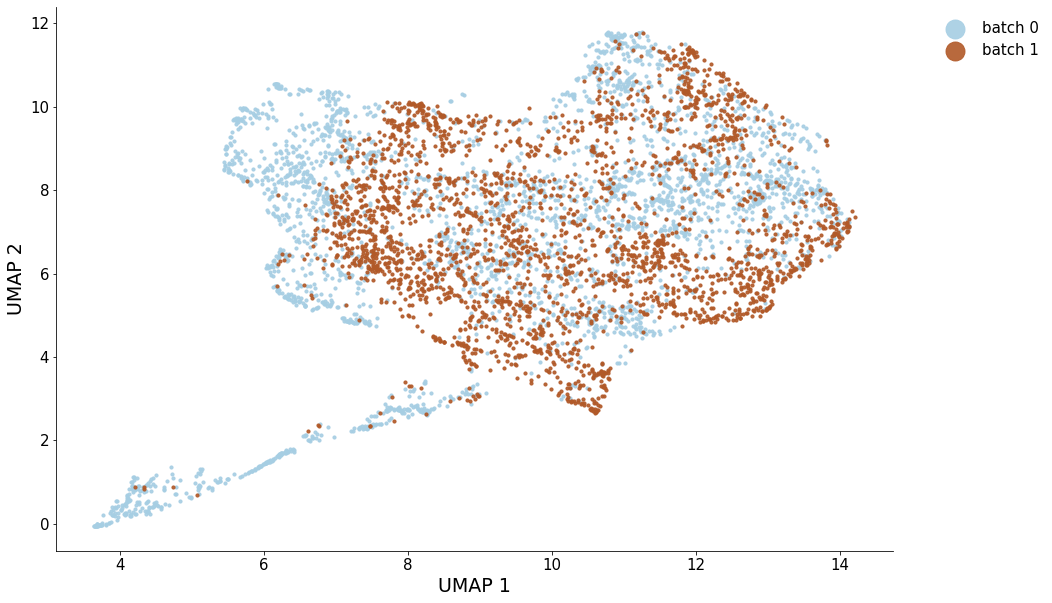

In [62]:
zs = []
import time
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['time_point'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, group_dim + time_dim:])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME_NO_GROUP'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = None

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of batch 5 and 6
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


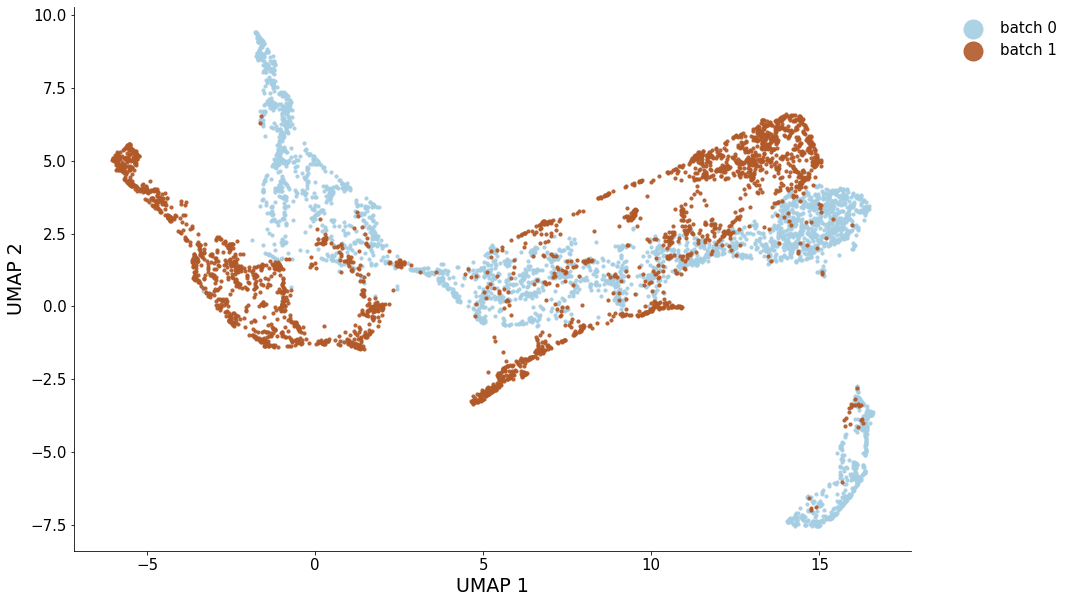

In [63]:
zs = []
import time

# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['time_point'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'WITH_TIME_GRP'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = None

utils.plot_latent(x_umaps, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos_sub, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of all 8 batches
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


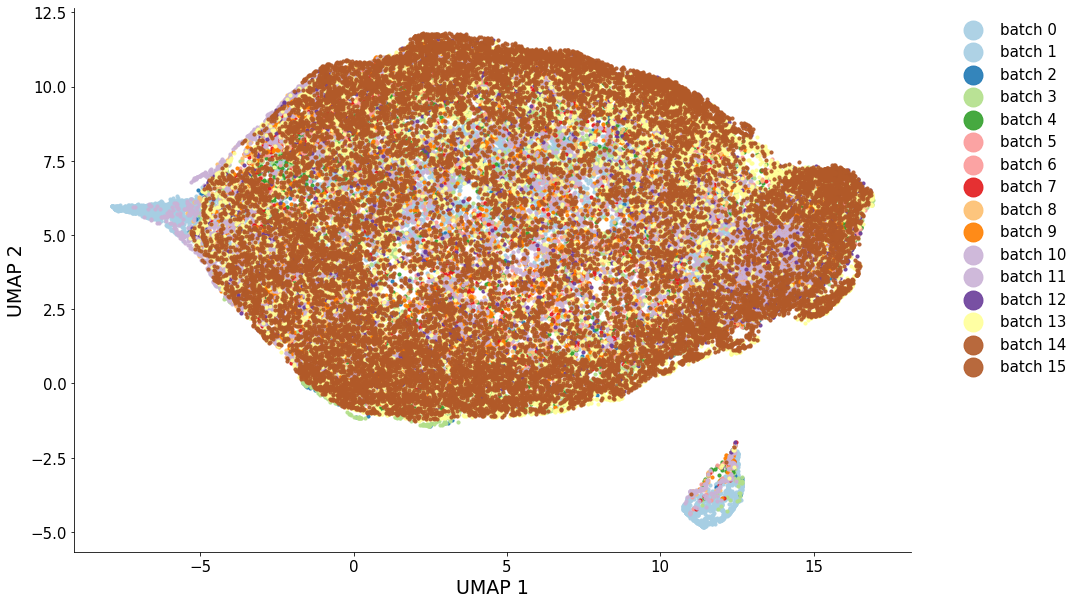

In [55]:
zs = []
annos_all = []
for data_batch in zip(*test_loaders_raw):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_all.append(x['time_point'])
            zs.append(z.cpu().detach().numpy())
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'ALL_TIME_GRP'
save_file_batch = path + 'batch_repro_{}_epoch_{}.png'.format(comment, n_epoches)

utils.plot_latent(x_umaps, annos = annos_all, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos_all, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")
